# Deep Convolutional GANs

In this notebook, you'll build a GAN using convolutional layers in the generator and discriminator. This is called a Deep Convolutional GAN, or DCGAN for short. The DCGAN architecture was first explored last year and has seen impressive results in generating new images, you can read the [original paper here](https://arxiv.org/pdf/1511.06434.pdf).

You'll be training DCGAN on the [Street View House Numbers](http://ufldl.stanford.edu/housenumbers/) (SVHN) dataset. These are color images of house numbers collected from Google street view. SVHN images are in color and much more variable than MNIST. 

![SVHN Examples](assets/SVHN_examples.png)

So, we'll need a deeper and more powerful network. This is accomplished through using convolutional layers in the discriminator and generator. It's also necessary to use batch normalization to get the convolutional networks to train. The only real changes compared to what [you saw previously](https://github.com/udacity/deep-learning/tree/master/gan_mnist) are in the generator and discriminator, otherwise the rest of the implementation is the same.

In [1]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [2]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


## Getting the data

Here you can download the SVHN dataset. Run the cell above and it'll download to your machine.

In [3]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

These SVHN files are `.mat` files typically used with Matlab. However, we can load them in with `scipy.io.loadmat` which we imported above.

In [4]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

Here I'm showing a small sample of the images. Each of these is 32x32 with 3 color channels (RGB). These are the real images we'll pass to the discriminator and what the generator will eventually fake.

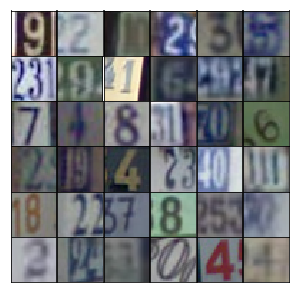

In [5]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

Here we need to do a bit of preprocessing and getting the images into a form where we can pass batches to the network. 
First off, we need to rescale the images to a range of -1 to 1, since the output of our generator is also in that range. 
We also have a set of test and validation images which could be used if we're trying to identify the numbers in the images.

In [6]:
# Scale works the same as Tanh
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [7]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(self.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

## Network Inputs

Here, just creating some placeholders like normal.

In [8]:
def model_inputs(input_dim):
    # Input data to the modal
    inputs = tf.placeholder(tf.float32, (None, *input_dim), name=None)
    
    # Indices/output/target/classes data to the model
    indices = tf.placeholder(tf.int32, (None), name=None)    
    
    return inputs, indices

## Generator

Here you'll build the generator network. The input will be our noise vector `z` as before. Also as before, the output will be a $tanh$ output, but this time with size 32x32 which is the size of our SVHN images.

What's new here is we'll use convolutional layers to create our new images. The first layer is a fully connected layer which is reshaped into a deep and narrow layer, something like 4x4x1024 as in the original DCGAN paper. Then we use batch normalization and a leaky ReLU activation. Next is a transposed convolution where typically you'd halve the depth and double the width and height of the previous layer. Again, we use batch normalization and leaky ReLU. For each of these layers, the general scheme is convolution > batch norm > leaky ReLU.

You keep stacking layers up like this until you get the final transposed convolution layer with shape 32x32x3. Below is the archicture used in the original DCGAN paper:

![DCGAN Generator](assets/dcgan.png)

Note that the final layer here is 64x64x3, while for our SVHN dataset, we only want it to be 32x32x3.

In [9]:
# tf.layers.conv2d(
#     inputs, ----------
#     filters, -------------
#     kernel_size, ------------
#     strides=(1, 1), ---------------
#     padding='valid', ------------
#     data_format='channels_last', -------------> NHWC and not NCHW
#     dilation_rate=(1, 1), -------------------
#     activation=None,
#     use_bias=True, ------------------
#     kernel_initializer=None,
#     bias_initializer=tf.zeros_initializer(), ------------------
#     kernel_regularizer=None,
#     bias_regularizer=None,
#     activity_regularizer=None,
#     kernel_constraint=None,
#     bias_constraint=None,
#     trainable=True, ---------------------
#     name=None,
#     reuse=None
# )

In [10]:
# Qfunction or qfunction, q/Q is quality and this is used as a classifier or q-learning or q-network
def qfunction(inputs, output_dim, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('qfunction', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(inputs=inputs, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(inputs=nl1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(inputs=nl2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it to the number of classes 
        # Let's imagine (4*4*512) is the number of classes.
        nl3_vec = tf.reshape(nl3, (-1, 4*4*256))
        #logits = tf.layers.dense(nl3_vec, 4*4*512)
        logits = tf.layers.dense(nl3_vec, output_dim) # this is for the classification task
        predictions = tf.nn.softmax(logits)
        # 4x4x512 now
        
        return logits, predictions

In [11]:
def generator(inputs, output_dim, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # Reshape it to start the convolutional stack
        h1 = tf.layers.dense(inputs, 4*4*512)
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        nl1_mat = tf.reshape(nl1, (-1, 4, 4, 512))
        # 4x4x512 now
        
        h2 = tf.layers.conv2d_transpose(inputs=nl1_mat, filters=256, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x256 now
        
        h3 = tf.layers.conv2d_transpose(inputs=nl2, filters=128, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(inputs=nl3, filters=output_dim, kernel_size=5, strides=2, padding='same')        
        predictions = tf.tanh(logits) # inputs data is scaled!
        # 32x32x3 now

        # generated input or input fake
        return predictions

## Discriminator

Here you'll build the discriminator. This is basically just a convolutional classifier like you've build before. The input to the discriminator are 32x32x3 tensors/images. You'll want a few convolutional layers, then a fully connected layer for the output. As before, we want a sigmoid output, and you'll need to return the logits as well. For the depths of the convolutional layers I suggest starting with 16, 32, 64 filters in the first layer, then double the depth as you add layers. Note that in the DCGAN paper, they did all the downsampling using only strided convolutional layers with no maxpool layers.

You'll also want to use batch normalization with `tf.layers.batch_normalization` on each layer except the first convolutional and output layers. Again, each layer should look something like convolution > batch norm > leaky ReLU. 

Note: in this project, your batch normalization layers will always use batch statistics. (That is, always set `training` to `True`.) That's because we are only interested in using the discriminator to help train the generator. However, if you wanted to use the discriminator for inference later, then you would need to set the `training` parameter appropriately.

In [12]:
def discriminator(inputs, reuse=False, alpha=0.1, training=True):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        h1 = tf.layers.conv2d(inputs=inputs, filters=64, kernel_size=5, strides=2, padding='same')
        bn1 = tf.layers.batch_normalization(h1, training=training)
        nl1 = tf.maximum(alpha * bn1, bn1)
        # 16x16x64
        
        h2 = tf.layers.conv2d(inputs=nl1, filters=128, kernel_size=5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(h2, training=training)
        nl2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        h3 = tf.layers.conv2d(inputs=nl2, filters=256, kernel_size=5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(h3, training=training)
        nl3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        nl3_vec = tf.reshape(nl3, (-1, 4*4*256))
        logits = tf.layers.dense(nl3_vec, 1)
        #predictions = tf.sigmoid(logits)
        
        return logits

## Model Loss

Calculating the loss like before, nothing new here.

In [13]:
# This is to determin the number of classes
trainset['y'].max(), trainset['y'].min()

(10, 1)

In [23]:
def model_loss(inputs_real, input_dim, indices_real, indices_dim):
    """
    Get the loss for the discriminator and generator
    :param inputs_real: Images from the real dataset
    :param input_dim: Input image dimensions
    :param indices_real: Target/output class/label numbers
    :param indices_dim: Number of output classes or dimensions
    :return: A tuple of (qfunction loss, generator loss, discriminator loss)
    """
    # Generating/reconstructing the fake inputs using real inputs
    q_logits, q_preds = qfunction(inputs=inputs_real, output_dim=indices_dim)
    inputs_fake = generator(inputs=q_preds, output_dim=input_dim)
    
    # Qfunction loss using real and fake inputs: Classification error
    q_loss = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits_v2(logits=q_logits, 
                                                   labels=tf.one_hot(depth=indices_dim, indices=indices_real)))

    # Discriminator logits fake and real for G & D losses
    d_logits_fake = discriminator(inputs=tf.sigmoid(inputs_fake), reuse=False)
    d_logits_real = discriminator(inputs=tf.sigmoid(inputs_real), reuse=True)

    # Generator loss
    g_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.zeros_like(d_logits_real)))
    g_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_logits_fake)))
    g_loss = g_loss_real + g_loss_fake

    # Reconstruction/prediction loss affects both Q & G
    loss_reconst = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=inputs_fake, labels=tf.sigmoid(inputs_real)))
    q_loss += loss_reconst
    g_loss += loss_reconst

    # Discriminator loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_logits_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_logits_fake)))
    d_loss = d_loss_real + d_loss_fake
    
    return q_loss, g_loss, d_loss

## Optimizers

Not much new here, but notice how the train operations are wrapped in a `with tf.control_dependencies` block so the batch normalization layers can update their population statistics.

In [24]:
def model_opt(q_loss, g_loss, d_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param q_loss: Qfunction loss Tensor
    :param g_loss: Generator loss Tensor
    :param d_loss: Discriminator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    q_vars = [var for var in t_vars if var.name.startswith('qfunction')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        q_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(q_loss, var_list=q_vars)
        g_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    return q_opt, g_opt, d_opt

## Building the model

Here we can use the functions we defined about to build the model as a class. This will make it easier to move the network around in our code since the nodes and operations in the graph are packaged in one object.

In [25]:
class GAN:
    def __init__(self, input_dim, indices_dim, learning_rate, beta1):
        tf.reset_default_graph()
        
        # Model inputs/data 
        self.inputs_real, self.indices_real = model_inputs(input_dim=input_dim)
        
        # Model losses/logits
        self.q_loss, self.g_loss, self.d_loss = model_loss(inputs_real=self.inputs_real, input_dim=input_dim[2],
                                                           indices_real=self.indices_real, indices_dim=indices_dim)

        # Model update/optimization
        self.q_opt, self.g_opt, self.d_opt = model_opt(q_loss=self.q_loss, 
                                                       g_loss=self.g_loss, 
                                                       d_loss=self.d_loss, 
                                                       learning_rate=learning_rate, beta1=beta1)

Here is a function for displaying generated images.

In [26]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

And another function we can use to train our network. Notice when we call `generator` to create the samples to display, we set `training` to `False`. That's so the batch normalization layers will use the population statistics rather than the batch statistics. Also notice that we set the `net.input_real` placeholder when we run the generator's optimizer. The generator doesn't actually use it, but we'd get an error without it because of the `tf.control_dependencies` block we created in `model_opt`. 

In [27]:
def train(model, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    samples, losses = [], []
    steps = 0

    # Creating a session for training
    with tf.Session() as sess:
        
        # Initialize the model variable if there is no model available to load/restore
        sess.run(tf.global_variables_initializer())
        
        #         # Restore/load the trained model
        #         #saver.restore(sess, './checkpoints/Auto-DCGAN.ckpt')
        #         saver.restore(sess, tf.train.latest_checkpoint('checkpoints/'))
        
        # Number of epochs for updating the model/s
        for e in range(epochs):
            
            # Training batches
            for inputs_real, indices_real in dataset.batches(batch_size):
                steps += 1

                # Run optimizers
                feed_dict={model.inputs_real: inputs_real, model.indices_real: indices_real}
                _ = sess.run(model.q_opt, feed_dict)
                _ = sess.run(model.g_opt, feed_dict)
                _ = sess.run(model.d_opt, feed_dict)

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    q_loss = model.q_loss.eval(feed_dict)
                    g_loss = model.g_loss.eval(feed_dict)
                    d_loss = model.d_loss.eval(feed_dict)

                    print("Epoch {}/{}".format(e+1, epochs),
                          "Qfunction Loss:{:.4f}".format(q_loss),
                          "Generator Loss:{:.4f}".format(g_loss),
                          "Discriminator Loss:{:.4f}".format(d_loss))
                    
                    # Save losses to view after training
                    losses.append((q_loss, g_loss, d_loss))

                if steps % show_every == 0:
                    _, model_qpreds = qfunction(inputs=model.inputs_real, output_dim=10, reuse=True, training=False)
                    model_glogits = generator(inputs=model_qpreds, output_dim=3, reuse=True, training=False)
                    glogits = sess.run(model_glogits, feed_dict)
                    #reconst_inputs = glogits
                    samples.append(glogits)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        # Save the trained model
        saver.save(sess, './checkpoints/model2.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

## Hyperparameters

GANs are very sensitive to hyperparameters. A lot of experimentation goes into finding the best hyperparameters such that the generator and discriminator don't overpower each other. Try out your own hyperparameters or read [the DCGAN paper](https://arxiv.org/pdf/1511.06434.pdf) to see what worked for them.

In [28]:
# ADAM default parameters
# __init__(
#     learning_rate=0.001,
#     beta1=0.9,
#     beta2=0.999,
#     epsilon=1e-08,
#     use_locking=False,
#     name='Adam'
# )

In [29]:
# Dataset for the model
dataset = Dataset(trainset, testset)

In [30]:
dataset.train_y.shape, dataset.train_y.max()

((73257, 1), 10)

In [31]:
image_size = (32,32,3)
num_classes = 10
learning_rate = 0.001
beta1 = 0.5
batch_size = 128
epochs = 10
alpha = 0.1

# Create the network
model = GAN(input_dim=image_size, indices_dim=num_classes, learning_rate=learning_rate, beta1=beta1)

Epoch 1/10 Qfunction Loss:1.7331 Generator Loss:3.2922 Discriminator Loss:1.3088
Epoch 1/10 Qfunction Loss:1.2797 Generator Loss:3.6175 Discriminator Loss:0.9160
Epoch 1/10 Qfunction Loss:0.8326 Generator Loss:3.6281 Discriminator Loss:0.8923
Epoch 1/10 Qfunction Loss:0.8593 Generator Loss:3.3928 Discriminator Loss:0.9248
Epoch 1/10 Qfunction Loss:0.5826 Generator Loss:3.3030 Discriminator Loss:1.4877
Epoch 1/10 Qfunction Loss:0.5558 Generator Loss:3.8072 Discriminator Loss:1.4837
Epoch 1/10 Qfunction Loss:0.3670 Generator Loss:3.2689 Discriminator Loss:1.0626
Epoch 1/10 Qfunction Loss:0.4441 Generator Loss:3.5087 Discriminator Loss:0.8143
Epoch 1/10 Qfunction Loss:0.4260 Generator Loss:3.4434 Discriminator Loss:0.6911
Epoch 1/10 Qfunction Loss:0.6374 Generator Loss:2.8463 Discriminator Loss:1.0553


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/matplotlib/axes/_base.py:1400: MatplotlibDeprecationWarning: The 'box-forced' keyword argument is deprecated since 2.2.
  " since 2.2.", cbook.mplDeprecation)


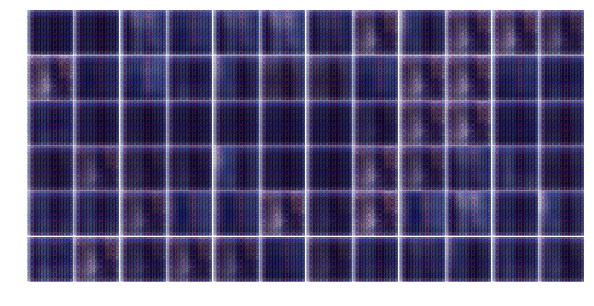

Epoch 1/10 Qfunction Loss:0.5210 Generator Loss:2.9505 Discriminator Loss:0.9086
Epoch 1/10 Qfunction Loss:0.6931 Generator Loss:2.6870 Discriminator Loss:1.1246
Epoch 1/10 Qfunction Loss:0.5746 Generator Loss:3.0370 Discriminator Loss:0.9015
Epoch 1/10 Qfunction Loss:0.4945 Generator Loss:2.6941 Discriminator Loss:1.0492
Epoch 1/10 Qfunction Loss:0.6658 Generator Loss:3.0340 Discriminator Loss:0.9747
Epoch 1/10 Qfunction Loss:0.7827 Generator Loss:3.0476 Discriminator Loss:1.0364
Epoch 1/10 Qfunction Loss:0.5007 Generator Loss:2.9428 Discriminator Loss:1.0689
Epoch 1/10 Qfunction Loss:0.8586 Generator Loss:2.7088 Discriminator Loss:1.0782
Epoch 1/10 Qfunction Loss:0.4519 Generator Loss:2.9811 Discriminator Loss:0.9314
Epoch 1/10 Qfunction Loss:1.0303 Generator Loss:2.7350 Discriminator Loss:1.0771


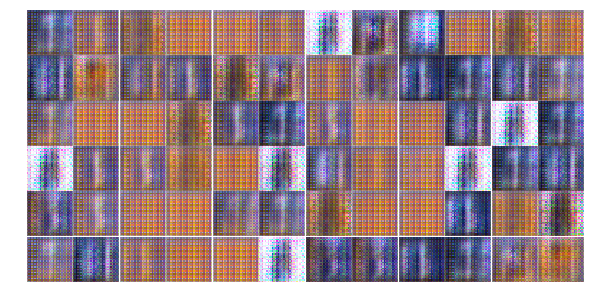

Epoch 1/10 Qfunction Loss:0.3688 Generator Loss:3.2586 Discriminator Loss:1.1901
Epoch 1/10 Qfunction Loss:0.5539 Generator Loss:2.6797 Discriminator Loss:1.5073
Epoch 1/10 Qfunction Loss:0.5692 Generator Loss:2.8629 Discriminator Loss:0.9388
Epoch 1/10 Qfunction Loss:0.7858 Generator Loss:2.7207 Discriminator Loss:1.0302
Epoch 1/10 Qfunction Loss:0.6308 Generator Loss:3.0520 Discriminator Loss:0.9699
Epoch 1/10 Qfunction Loss:0.8662 Generator Loss:3.3028 Discriminator Loss:0.9953
Epoch 1/10 Qfunction Loss:0.5448 Generator Loss:2.8290 Discriminator Loss:0.9695
Epoch 1/10 Qfunction Loss:0.5986 Generator Loss:5.3934 Discriminator Loss:0.4792
Epoch 1/10 Qfunction Loss:0.6534 Generator Loss:2.8941 Discriminator Loss:1.0785
Epoch 1/10 Qfunction Loss:0.4783 Generator Loss:4.2117 Discriminator Loss:0.5823


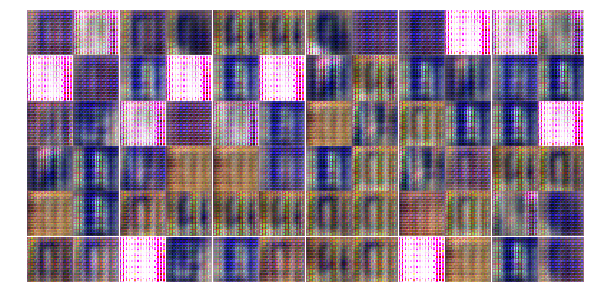

Epoch 1/10 Qfunction Loss:0.6270 Generator Loss:3.1160 Discriminator Loss:0.7833
Epoch 1/10 Qfunction Loss:0.4377 Generator Loss:3.3217 Discriminator Loss:1.0075
Epoch 1/10 Qfunction Loss:0.8599 Generator Loss:3.1337 Discriminator Loss:0.8041
Epoch 1/10 Qfunction Loss:0.9586 Generator Loss:3.5508 Discriminator Loss:0.8537
Epoch 1/10 Qfunction Loss:0.9446 Generator Loss:2.9406 Discriminator Loss:0.9961
Epoch 1/10 Qfunction Loss:0.5589 Generator Loss:3.8250 Discriminator Loss:0.7465
Epoch 1/10 Qfunction Loss:0.4941 Generator Loss:3.5420 Discriminator Loss:0.8223
Epoch 1/10 Qfunction Loss:0.4212 Generator Loss:2.6328 Discriminator Loss:1.1201
Epoch 1/10 Qfunction Loss:0.6147 Generator Loss:3.0086 Discriminator Loss:1.0219
Epoch 1/10 Qfunction Loss:0.8297 Generator Loss:3.0141 Discriminator Loss:0.8624


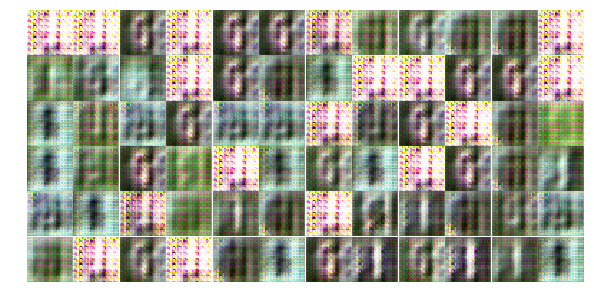

Epoch 1/10 Qfunction Loss:0.4866 Generator Loss:3.5336 Discriminator Loss:0.6588
Epoch 1/10 Qfunction Loss:0.8318 Generator Loss:2.8377 Discriminator Loss:1.2920
Epoch 1/10 Qfunction Loss:0.4353 Generator Loss:3.2055 Discriminator Loss:0.9281
Epoch 1/10 Qfunction Loss:1.1173 Generator Loss:2.6985 Discriminator Loss:1.2460
Epoch 1/10 Qfunction Loss:0.3552 Generator Loss:3.0395 Discriminator Loss:0.8304
Epoch 1/10 Qfunction Loss:0.9576 Generator Loss:2.4401 Discriminator Loss:1.3165
Epoch 1/10 Qfunction Loss:1.2693 Generator Loss:3.1657 Discriminator Loss:0.8486
Epoch 1/10 Qfunction Loss:1.2831 Generator Loss:3.8736 Discriminator Loss:0.6325
Epoch 1/10 Qfunction Loss:0.3485 Generator Loss:4.2107 Discriminator Loss:1.2408
Epoch 1/10 Qfunction Loss:0.6470 Generator Loss:3.4057 Discriminator Loss:0.7158


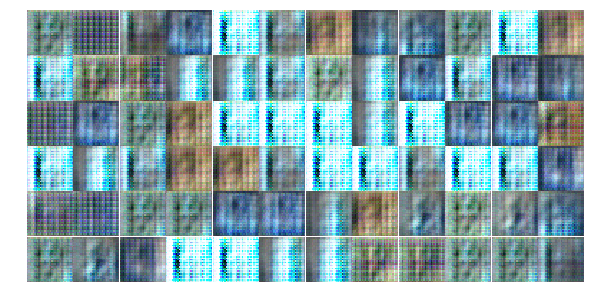

Epoch 1/10 Qfunction Loss:1.5704 Generator Loss:2.6247 Discriminator Loss:1.4761
Epoch 1/10 Qfunction Loss:1.0336 Generator Loss:3.2420 Discriminator Loss:0.7393
Epoch 1/10 Qfunction Loss:0.9278 Generator Loss:2.5286 Discriminator Loss:1.2179
Epoch 1/10 Qfunction Loss:1.1949 Generator Loss:2.9536 Discriminator Loss:1.1511
Epoch 1/10 Qfunction Loss:1.4348 Generator Loss:3.3430 Discriminator Loss:0.8508
Epoch 1/10 Qfunction Loss:1.0847 Generator Loss:2.9138 Discriminator Loss:1.0010
Epoch 1/10 Qfunction Loss:0.7235 Generator Loss:3.4104 Discriminator Loss:0.7405
Epoch 2/10 Qfunction Loss:1.2064 Generator Loss:2.8511 Discriminator Loss:0.9814
Epoch 2/10 Qfunction Loss:0.5700 Generator Loss:2.9135 Discriminator Loss:0.9119
Epoch 2/10 Qfunction Loss:1.0477 Generator Loss:3.1018 Discriminator Loss:0.8530


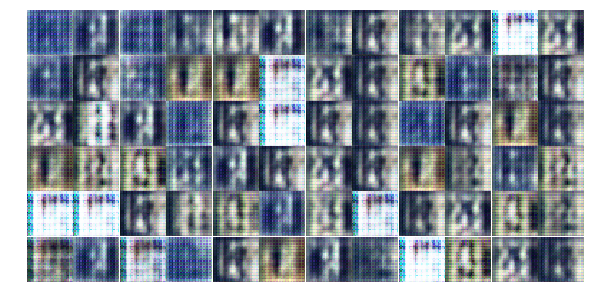

Epoch 2/10 Qfunction Loss:0.5420 Generator Loss:2.8954 Discriminator Loss:0.9460
Epoch 2/10 Qfunction Loss:0.6858 Generator Loss:2.8530 Discriminator Loss:1.1715
Epoch 2/10 Qfunction Loss:1.2406 Generator Loss:3.2305 Discriminator Loss:1.0201
Epoch 2/10 Qfunction Loss:0.9543 Generator Loss:3.2301 Discriminator Loss:1.5235
Epoch 2/10 Qfunction Loss:0.4824 Generator Loss:2.9220 Discriminator Loss:1.0087
Epoch 2/10 Qfunction Loss:0.9097 Generator Loss:2.8693 Discriminator Loss:0.9660
Epoch 2/10 Qfunction Loss:1.9979 Generator Loss:3.5324 Discriminator Loss:1.0886
Epoch 2/10 Qfunction Loss:2.9907 Generator Loss:3.7036 Discriminator Loss:1.2687
Epoch 2/10 Qfunction Loss:0.5156 Generator Loss:3.9324 Discriminator Loss:0.5685
Epoch 2/10 Qfunction Loss:0.7830 Generator Loss:2.9987 Discriminator Loss:0.9295


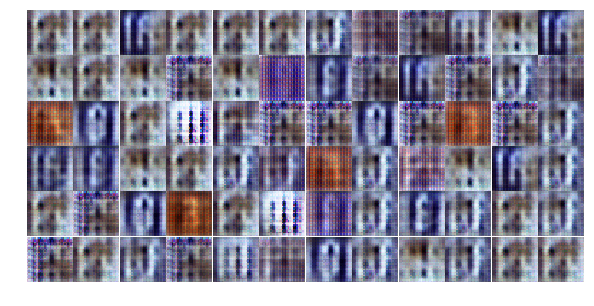

Epoch 2/10 Qfunction Loss:1.7548 Generator Loss:3.7142 Discriminator Loss:0.6138
Epoch 2/10 Qfunction Loss:1.5484 Generator Loss:3.4753 Discriminator Loss:0.8500
Epoch 2/10 Qfunction Loss:0.9273 Generator Loss:2.4486 Discriminator Loss:1.3291
Epoch 2/10 Qfunction Loss:1.6345 Generator Loss:2.5860 Discriminator Loss:1.1037
Epoch 2/10 Qfunction Loss:1.0505 Generator Loss:2.8809 Discriminator Loss:1.2803
Epoch 2/10 Qfunction Loss:0.6384 Generator Loss:2.8228 Discriminator Loss:0.9313
Epoch 2/10 Qfunction Loss:1.1489 Generator Loss:3.1374 Discriminator Loss:0.8435
Epoch 2/10 Qfunction Loss:1.8907 Generator Loss:2.7842 Discriminator Loss:1.1728
Epoch 2/10 Qfunction Loss:1.0017 Generator Loss:2.4070 Discriminator Loss:1.2790
Epoch 2/10 Qfunction Loss:1.8940 Generator Loss:2.7395 Discriminator Loss:1.0586


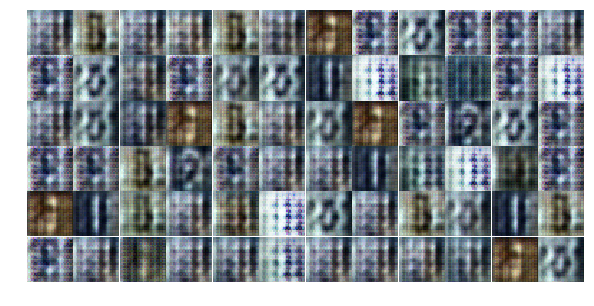

Epoch 2/10 Qfunction Loss:1.3044 Generator Loss:2.8291 Discriminator Loss:1.0621
Epoch 2/10 Qfunction Loss:1.1067 Generator Loss:3.1617 Discriminator Loss:0.9425
Epoch 2/10 Qfunction Loss:1.2804 Generator Loss:3.3549 Discriminator Loss:0.7277
Epoch 2/10 Qfunction Loss:2.1130 Generator Loss:2.7804 Discriminator Loss:1.0830
Epoch 2/10 Qfunction Loss:1.3629 Generator Loss:3.0259 Discriminator Loss:1.0415
Epoch 2/10 Qfunction Loss:1.3438 Generator Loss:3.0457 Discriminator Loss:1.2098
Epoch 2/10 Qfunction Loss:1.0255 Generator Loss:2.7611 Discriminator Loss:0.9884
Epoch 2/10 Qfunction Loss:3.8657 Generator Loss:2.5932 Discriminator Loss:1.2654
Epoch 2/10 Qfunction Loss:1.8394 Generator Loss:3.0666 Discriminator Loss:0.8465
Epoch 2/10 Qfunction Loss:1.3835 Generator Loss:3.4758 Discriminator Loss:0.7159


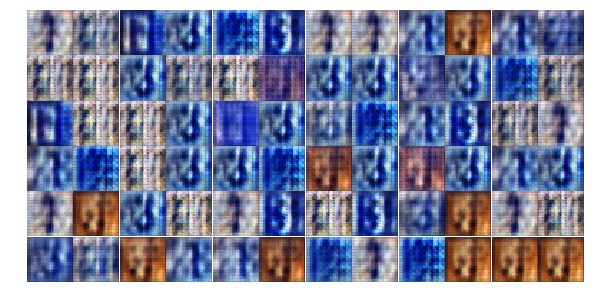

Epoch 2/10 Qfunction Loss:1.5708 Generator Loss:2.8647 Discriminator Loss:1.3779
Epoch 2/10 Qfunction Loss:4.6776 Generator Loss:2.6975 Discriminator Loss:1.1433
Epoch 2/10 Qfunction Loss:0.8008 Generator Loss:2.7832 Discriminator Loss:1.1304
Epoch 2/10 Qfunction Loss:0.6195 Generator Loss:3.5124 Discriminator Loss:0.6631
Epoch 2/10 Qfunction Loss:2.1416 Generator Loss:3.0564 Discriminator Loss:0.9078
Epoch 2/10 Qfunction Loss:3.1976 Generator Loss:3.1760 Discriminator Loss:0.8613
Epoch 2/10 Qfunction Loss:1.1679 Generator Loss:2.6095 Discriminator Loss:1.1851
Epoch 2/10 Qfunction Loss:0.6743 Generator Loss:2.7754 Discriminator Loss:0.9948
Epoch 2/10 Qfunction Loss:1.4039 Generator Loss:3.2610 Discriminator Loss:0.9878
Epoch 2/10 Qfunction Loss:1.0848 Generator Loss:2.9051 Discriminator Loss:1.0139


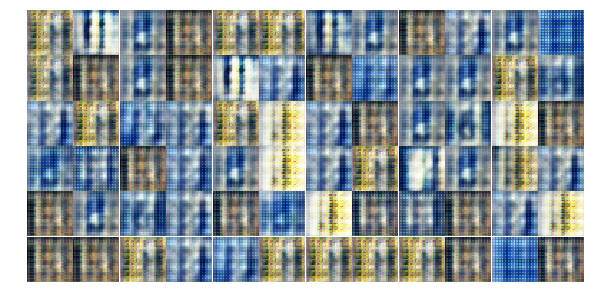

Epoch 2/10 Qfunction Loss:1.8874 Generator Loss:3.0431 Discriminator Loss:0.8148
Epoch 2/10 Qfunction Loss:1.1830 Generator Loss:3.5459 Discriminator Loss:0.8931
Epoch 2/10 Qfunction Loss:1.5439 Generator Loss:3.2353 Discriminator Loss:0.7471
Epoch 2/10 Qfunction Loss:1.5259 Generator Loss:3.0287 Discriminator Loss:0.8775
Epoch 2/10 Qfunction Loss:1.8885 Generator Loss:3.2831 Discriminator Loss:0.9465
Epoch 2/10 Qfunction Loss:3.6227 Generator Loss:3.1367 Discriminator Loss:1.0023
Epoch 2/10 Qfunction Loss:2.3983 Generator Loss:3.1132 Discriminator Loss:0.8788
Epoch 2/10 Qfunction Loss:2.4011 Generator Loss:3.3389 Discriminator Loss:0.8474
Epoch 2/10 Qfunction Loss:3.6830 Generator Loss:3.1427 Discriminator Loss:0.9275
Epoch 2/10 Qfunction Loss:1.0322 Generator Loss:3.0636 Discriminator Loss:0.9076


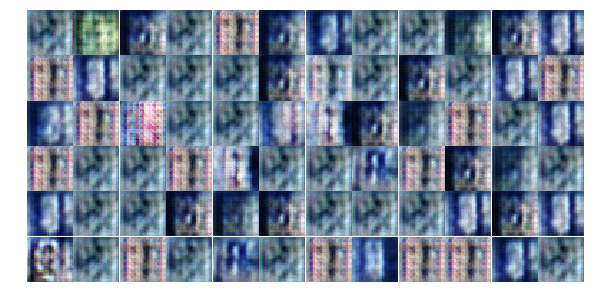

Epoch 2/10 Qfunction Loss:1.9276 Generator Loss:2.7283 Discriminator Loss:1.0724
Epoch 2/10 Qfunction Loss:1.5228 Generator Loss:2.9338 Discriminator Loss:0.9439
Epoch 2/10 Qfunction Loss:2.0880 Generator Loss:3.0291 Discriminator Loss:1.0276
Epoch 2/10 Qfunction Loss:3.5570 Generator Loss:3.1790 Discriminator Loss:0.8429
Epoch 3/10 Qfunction Loss:2.1777 Generator Loss:3.2713 Discriminator Loss:0.9061
Epoch 3/10 Qfunction Loss:1.5495 Generator Loss:3.0964 Discriminator Loss:0.8513
Epoch 3/10 Qfunction Loss:0.9014 Generator Loss:3.4108 Discriminator Loss:1.2911
Epoch 3/10 Qfunction Loss:1.6980 Generator Loss:3.3462 Discriminator Loss:0.7972
Epoch 3/10 Qfunction Loss:1.2206 Generator Loss:3.0165 Discriminator Loss:0.8926
Epoch 3/10 Qfunction Loss:5.4283 Generator Loss:3.1033 Discriminator Loss:0.9020


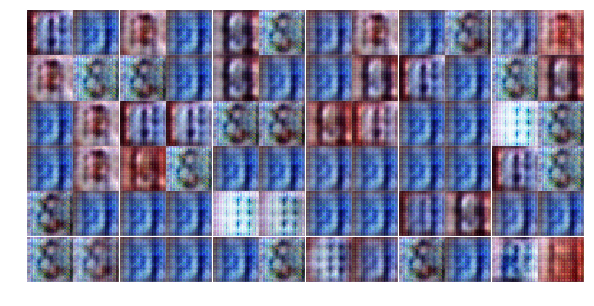

Epoch 3/10 Qfunction Loss:2.0404 Generator Loss:3.3319 Discriminator Loss:0.9039
Epoch 3/10 Qfunction Loss:0.9286 Generator Loss:3.0562 Discriminator Loss:0.8721
Epoch 3/10 Qfunction Loss:1.5589 Generator Loss:2.6543 Discriminator Loss:1.1005
Epoch 3/10 Qfunction Loss:2.7404 Generator Loss:3.5818 Discriminator Loss:1.0042
Epoch 3/10 Qfunction Loss:2.0238 Generator Loss:3.2490 Discriminator Loss:0.8177
Epoch 3/10 Qfunction Loss:2.0964 Generator Loss:4.0130 Discriminator Loss:0.9325
Epoch 3/10 Qfunction Loss:3.2372 Generator Loss:2.7605 Discriminator Loss:1.1984
Epoch 3/10 Qfunction Loss:3.5465 Generator Loss:3.2076 Discriminator Loss:0.8912
Epoch 3/10 Qfunction Loss:2.3335 Generator Loss:3.0378 Discriminator Loss:0.9565
Epoch 3/10 Qfunction Loss:1.0375 Generator Loss:3.2884 Discriminator Loss:0.7983


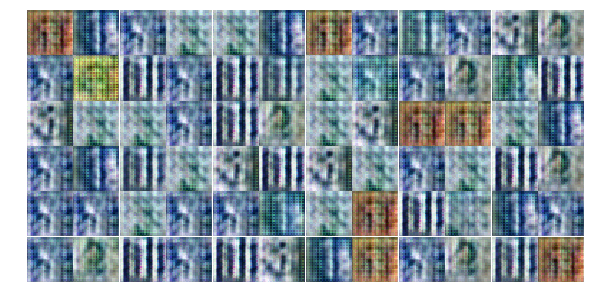

Epoch 3/10 Qfunction Loss:2.9054 Generator Loss:2.9105 Discriminator Loss:0.9647
Epoch 3/10 Qfunction Loss:2.0841 Generator Loss:3.3963 Discriminator Loss:0.8966
Epoch 3/10 Qfunction Loss:2.2629 Generator Loss:3.5071 Discriminator Loss:0.8059
Epoch 3/10 Qfunction Loss:0.9506 Generator Loss:3.4311 Discriminator Loss:0.9331
Epoch 3/10 Qfunction Loss:1.7763 Generator Loss:3.1012 Discriminator Loss:1.1440
Epoch 3/10 Qfunction Loss:4.7337 Generator Loss:3.3141 Discriminator Loss:0.7839
Epoch 3/10 Qfunction Loss:2.9274 Generator Loss:3.6996 Discriminator Loss:0.7864
Epoch 3/10 Qfunction Loss:1.9509 Generator Loss:3.0903 Discriminator Loss:0.8291
Epoch 3/10 Qfunction Loss:2.8922 Generator Loss:3.4064 Discriminator Loss:1.1171
Epoch 3/10 Qfunction Loss:2.2556 Generator Loss:3.4276 Discriminator Loss:0.7119


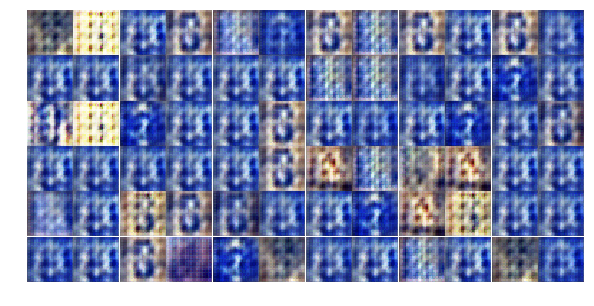

Epoch 3/10 Qfunction Loss:2.1261 Generator Loss:3.0428 Discriminator Loss:0.9951
Epoch 3/10 Qfunction Loss:1.8245 Generator Loss:3.1426 Discriminator Loss:0.8210
Epoch 3/10 Qfunction Loss:2.6496 Generator Loss:3.2127 Discriminator Loss:0.8340
Epoch 3/10 Qfunction Loss:2.2393 Generator Loss:3.5202 Discriminator Loss:0.9717
Epoch 3/10 Qfunction Loss:2.4016 Generator Loss:3.8353 Discriminator Loss:0.9103
Epoch 3/10 Qfunction Loss:1.1981 Generator Loss:2.8452 Discriminator Loss:1.0459
Epoch 3/10 Qfunction Loss:1.8220 Generator Loss:3.2133 Discriminator Loss:0.8196
Epoch 3/10 Qfunction Loss:2.7641 Generator Loss:3.4534 Discriminator Loss:1.0613
Epoch 3/10 Qfunction Loss:4.0186 Generator Loss:3.0443 Discriminator Loss:0.8490
Epoch 3/10 Qfunction Loss:2.8572 Generator Loss:3.0609 Discriminator Loss:0.9468


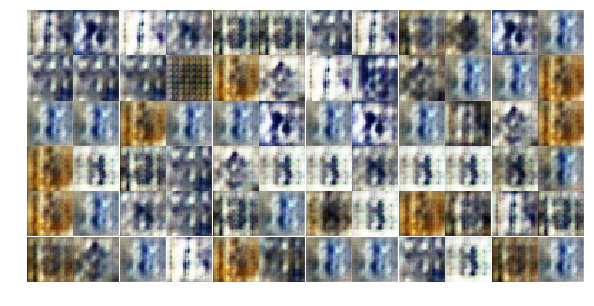

Epoch 3/10 Qfunction Loss:2.2779 Generator Loss:3.2837 Discriminator Loss:0.9114
Epoch 3/10 Qfunction Loss:3.0027 Generator Loss:3.0054 Discriminator Loss:0.9546
Epoch 3/10 Qfunction Loss:2.1012 Generator Loss:3.2105 Discriminator Loss:0.8429
Epoch 3/10 Qfunction Loss:2.0848 Generator Loss:3.7740 Discriminator Loss:0.6177
Epoch 3/10 Qfunction Loss:4.7392 Generator Loss:3.3995 Discriminator Loss:0.8458
Epoch 3/10 Qfunction Loss:1.5687 Generator Loss:3.6965 Discriminator Loss:0.9200
Epoch 3/10 Qfunction Loss:1.8314 Generator Loss:3.3200 Discriminator Loss:0.7914
Epoch 3/10 Qfunction Loss:1.1291 Generator Loss:2.8075 Discriminator Loss:1.1340
Epoch 3/10 Qfunction Loss:3.0071 Generator Loss:3.1582 Discriminator Loss:0.9199
Epoch 3/10 Qfunction Loss:2.7557 Generator Loss:3.1120 Discriminator Loss:0.8944


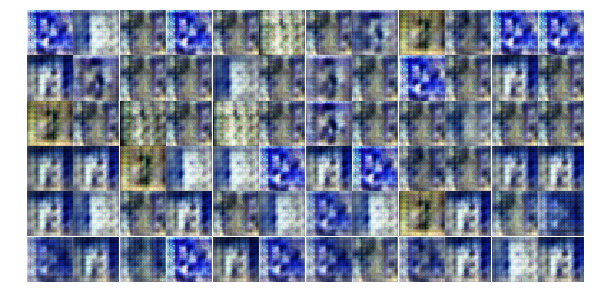

Epoch 3/10 Qfunction Loss:1.4655 Generator Loss:2.9977 Discriminator Loss:0.9199
Epoch 3/10 Qfunction Loss:2.2627 Generator Loss:2.9281 Discriminator Loss:0.9632
Epoch 3/10 Qfunction Loss:2.3763 Generator Loss:3.0704 Discriminator Loss:0.9171
Epoch 3/10 Qfunction Loss:1.8003 Generator Loss:3.2065 Discriminator Loss:0.8252
Epoch 3/10 Qfunction Loss:1.0071 Generator Loss:3.4918 Discriminator Loss:0.7924
Epoch 3/10 Qfunction Loss:0.9411 Generator Loss:4.0815 Discriminator Loss:1.3634
Epoch 3/10 Qfunction Loss:2.9915 Generator Loss:3.2767 Discriminator Loss:0.8082
Epoch 3/10 Qfunction Loss:3.6373 Generator Loss:3.4113 Discriminator Loss:0.7388
Epoch 3/10 Qfunction Loss:2.4964 Generator Loss:3.5735 Discriminator Loss:1.6427
Epoch 3/10 Qfunction Loss:2.8787 Generator Loss:3.2150 Discriminator Loss:0.9472


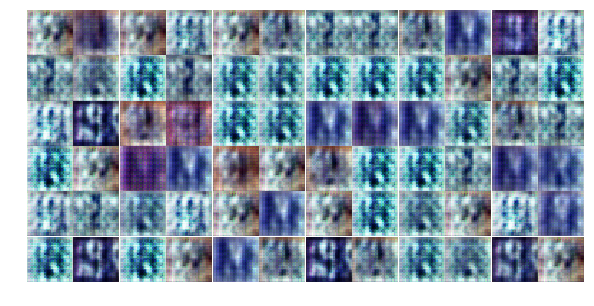

Epoch 3/10 Qfunction Loss:3.9502 Generator Loss:3.2328 Discriminator Loss:0.8341
Epoch 4/10 Qfunction Loss:1.4745 Generator Loss:4.2760 Discriminator Loss:0.6902
Epoch 4/10 Qfunction Loss:2.6773 Generator Loss:3.2737 Discriminator Loss:0.7824
Epoch 4/10 Qfunction Loss:5.9996 Generator Loss:3.8997 Discriminator Loss:1.2725
Epoch 4/10 Qfunction Loss:4.1357 Generator Loss:3.2811 Discriminator Loss:1.0528
Epoch 4/10 Qfunction Loss:2.8059 Generator Loss:3.6644 Discriminator Loss:1.2680
Epoch 4/10 Qfunction Loss:1.9646 Generator Loss:3.0073 Discriminator Loss:0.9525
Epoch 4/10 Qfunction Loss:3.0208 Generator Loss:3.5128 Discriminator Loss:0.7585
Epoch 4/10 Qfunction Loss:2.7956 Generator Loss:3.3101 Discriminator Loss:0.8899
Epoch 4/10 Qfunction Loss:1.5885 Generator Loss:2.9819 Discriminator Loss:0.9718


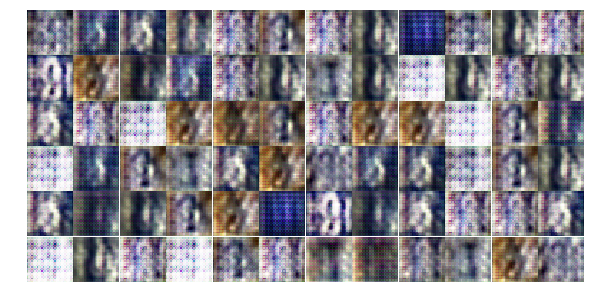

Epoch 4/10 Qfunction Loss:2.8857 Generator Loss:3.6832 Discriminator Loss:0.9982
Epoch 4/10 Qfunction Loss:3.0163 Generator Loss:3.4038 Discriminator Loss:0.9409
Epoch 4/10 Qfunction Loss:1.6974 Generator Loss:3.2665 Discriminator Loss:0.8476
Epoch 4/10 Qfunction Loss:4.6326 Generator Loss:3.1810 Discriminator Loss:0.8642
Epoch 4/10 Qfunction Loss:3.0180 Generator Loss:4.0828 Discriminator Loss:1.4147
Epoch 4/10 Qfunction Loss:6.9012 Generator Loss:3.2418 Discriminator Loss:0.9714
Epoch 4/10 Qfunction Loss:3.8129 Generator Loss:3.0648 Discriminator Loss:0.9134
Epoch 4/10 Qfunction Loss:3.6644 Generator Loss:2.9537 Discriminator Loss:0.9229
Epoch 4/10 Qfunction Loss:1.2826 Generator Loss:3.1509 Discriminator Loss:1.0639
Epoch 4/10 Qfunction Loss:2.7195 Generator Loss:3.4943 Discriminator Loss:1.1313


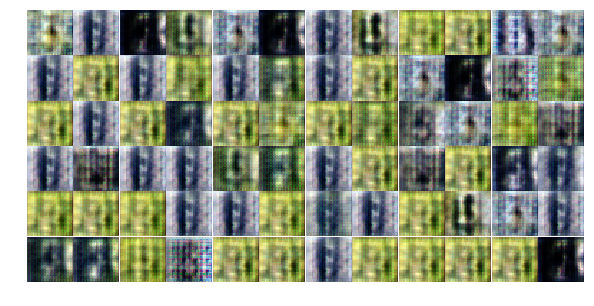

Epoch 4/10 Qfunction Loss:2.7146 Generator Loss:2.9933 Discriminator Loss:0.9582
Epoch 4/10 Qfunction Loss:2.5899 Generator Loss:3.6255 Discriminator Loss:0.6888
Epoch 4/10 Qfunction Loss:2.0401 Generator Loss:2.9649 Discriminator Loss:1.0291
Epoch 4/10 Qfunction Loss:3.6221 Generator Loss:3.5531 Discriminator Loss:0.7147
Epoch 4/10 Qfunction Loss:3.1402 Generator Loss:3.4210 Discriminator Loss:0.8290
Epoch 4/10 Qfunction Loss:2.7459 Generator Loss:3.6021 Discriminator Loss:0.7694
Epoch 4/10 Qfunction Loss:2.6878 Generator Loss:3.3671 Discriminator Loss:0.8072
Epoch 4/10 Qfunction Loss:1.0670 Generator Loss:3.6628 Discriminator Loss:0.6558
Epoch 4/10 Qfunction Loss:2.2715 Generator Loss:4.5664 Discriminator Loss:0.7549
Epoch 4/10 Qfunction Loss:6.2720 Generator Loss:3.1524 Discriminator Loss:0.9059


In [ ]:
losses, samples = train(model=model, dataset=dataset, epochs=epochs, batch_size=batch_size, figsize=(10,5))

In [ ]:
fig, ax = plt.subplots()
losses_ = np.array(losses)
losses_norm = (losses_ - losses_.mean(axis=0))/losses_.std(axis=0)
plt.plot(losses_norm.T[0], label='Qfunction', alpha=0.5)
plt.plot(losses_norm.T[1], label='Generator', alpha=0.5)
plt.plot(losses_norm.T[2], label='Discriminator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
fig, ax = plt.subplots()
plt.plot(losses_.T[0], label='Qfunction', alpha=0.5)
plt.plot(losses_.T[1], label='Generator', alpha=0.5)
plt.plot(losses_.T[2], label='Discriminator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

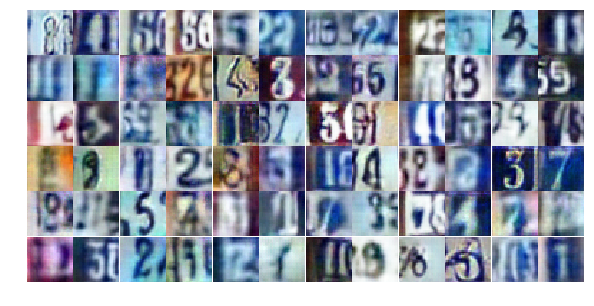

In [19]:
# Standard DCGAN
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))